# Diabetes prediction: decision tree

## Notebook set-up

This cell imports all necessary libraries for our diabetes prediction project:
- **Standard libraries**: `os`, `pickle`, `pathlib` for file operations
- **Data manipulation**: `pandas`, `numpy` for data handling and numerical operations
- **Visualization**: `matplotlib`, `seaborn` for creating plots and charts
- **Machine learning**: `scikit-learn` components for preprocessing, modeling, and evaluation
- **Project modules**: Custom configuration and utility functions

These imports provide the foundation for data loading, exploration, preprocessing, model training, and evaluation.

In [1]:
# Python standard library imports
import os
import pickle
from itertools import combinations
from pathlib import Path

# PyPI imports - data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyPI imports - statistical and machine learning libraries
from scipy.stats import randint, uniform, loguniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Internal imports - project-specific modules
import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from URL

We start by loading the diabetes dataset directly from a GitHub repository URL. The dataset contains medical measurements and diabetes outcomes for patients. After loading, we remove any duplicate rows to ensure data quality and reset the index for clean row numbering.

In [2]:
# Load diabetes dataset from GitHub repository
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df = pd.read_csv(url)

# Remove any duplicate rows and reset the index
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Save a local copy

We save a local copy of the raw data in Parquet format for several reasons:
- **Efficiency**: Parquet files are compressed and load faster than CSV
- **Reproducibility**: Having a local copy ensures we work with the same data even if the remote source changes
- **Organization**: Storing raw data separately from processed data maintains a clean data pipeline

In [3]:
# Create directory structure for raw data storage
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data in Parquet format for efficient storage
data_df.to_parquet(config.RAW_DATA_FILE)

### 1.3. Inspect

Let's examine the structure and basic properties of our dataset to understand what we're working with. The `.head()` method shows the first few rows, while `.info()` provides details about data types, null values, and memory usage.

In [4]:
data_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 2. EDA
### 2.1. Data composition

Understanding the distribution of each feature is crucial for identifying potential data quality issues and understanding the characteristics of our patient population. We create histograms for all 8 features to visualize:
- **Shape of distributions**: Are they normal, skewed, or have multiple peaks?
- **Outliers**: Are there extreme values that might need attention?
- **Zeros**: Some medical measurements shouldn't naturally be zero, indicating missing data

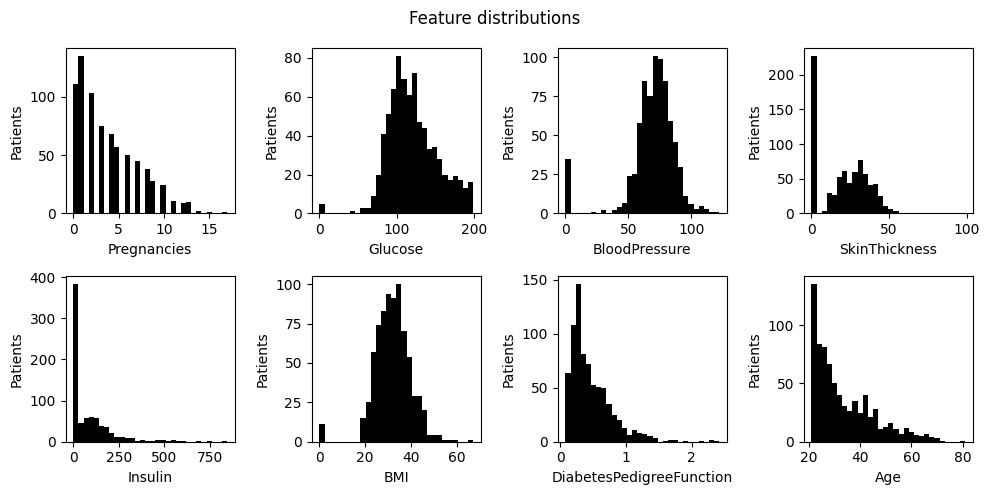

In [6]:
# Define the list of feature columns for analysis
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
            'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Create subplot grid for feature histograms (2 rows, 4 columns)
fig, axs = plt.subplots(2,4, figsize=(10,5))

# Flatten to make indexing easier
axs = axs.flatten()

fig.suptitle('Feature distributions')

# Plot histogram for each feature
for i, feature in enumerate(features):
    axs[i].hist(data_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Patients')

# Adjust layout to prevent overlapping
fig.tight_layout()

### 2.2. Feature interactions

#### 2.2.1. Feature cross-correlations

Feature correlations help us understand relationships between different medical measurements. Strong correlations might indicate:
- **Redundant features**: Two features measuring similar things
- **Biological relationships**: Expected medical correlations (e.g., BMI and skin thickness)
- **Multicollinearity**: Which could affect some machine learning algorithms

We create scatter plots for all possible feature pairs to visually identify these relationships.

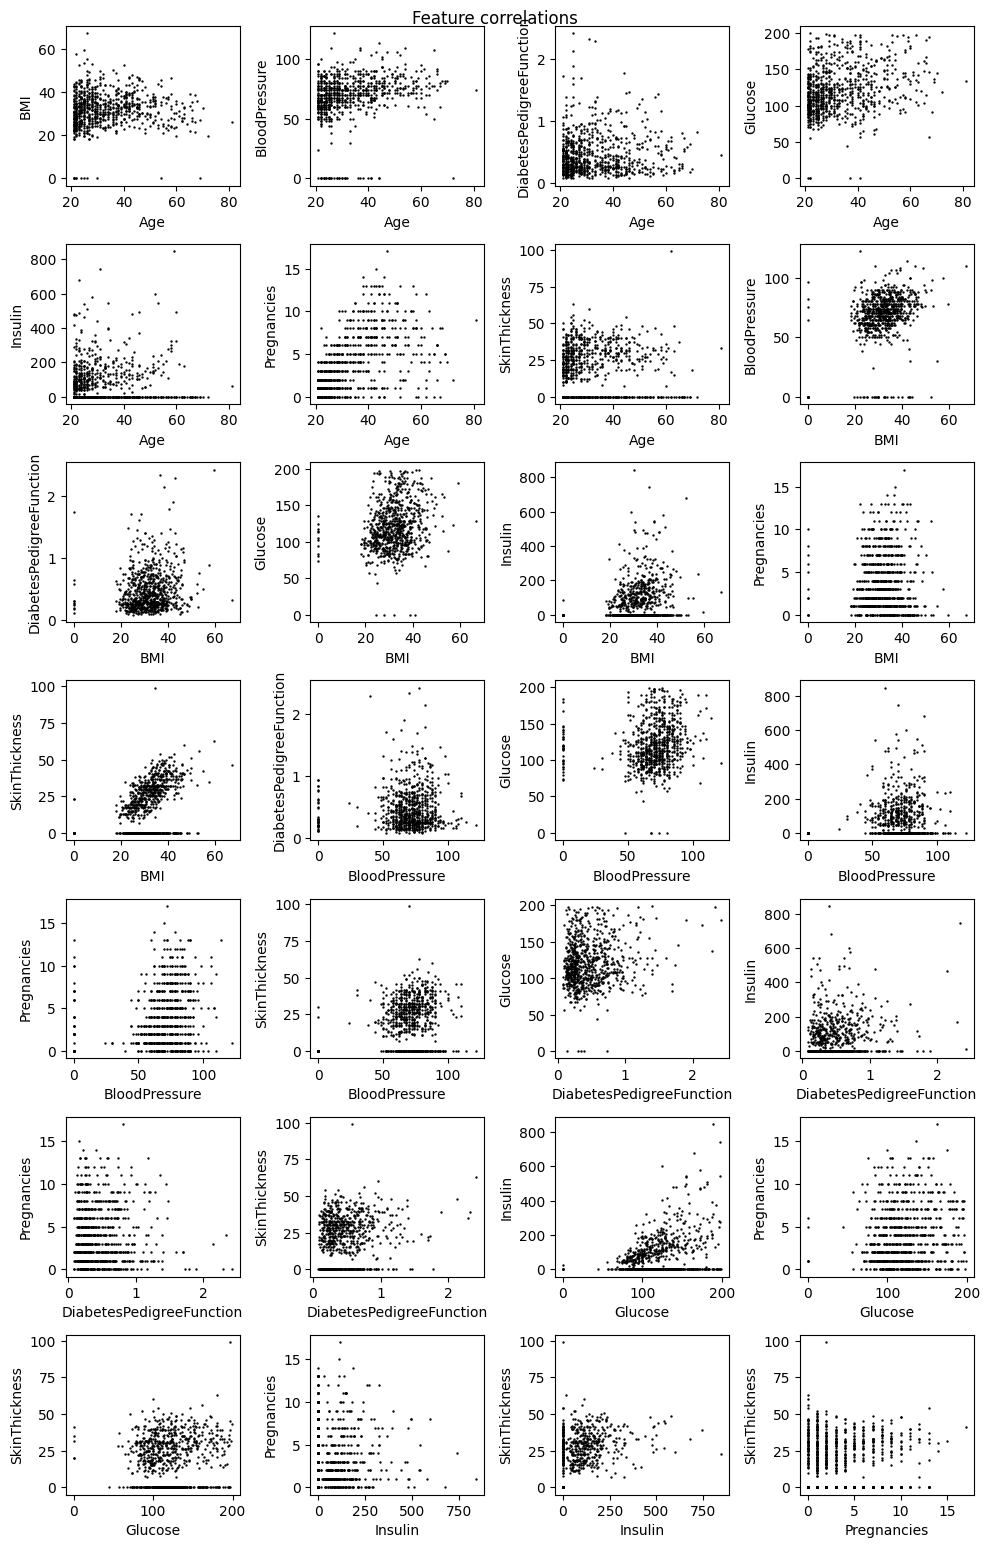

In [7]:
# Generate all possible pairs of features for correlation analysis
feature_pairs = sorted(map(sorted, combinations(set(features), 2)))
rows = len(feature_pairs) // 4  # Calculate number of rows needed

# Create subplot grid for scatter plots
fig, axs = plt.subplots(rows, 4, figsize=(10, rows*2.25))

# Flatten to make indexing easier
axs = axs.flatten()

fig.suptitle('Feature correlations')

# Create scatter plot for each feature pair
for i, feature_pair in enumerate(feature_pairs):
    axs[i].scatter(
        data_df[feature_pair[0]],
        data_df[feature_pair[1]],
        color='black',
        s=0.5  # Small point size for better visualization
    )
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

# Adjust layout to prevent overlapping
fig.tight_layout()

#### 2.2.2. Feature-label interactions

This analysis reveals how each feature differs between diabetic and non-diabetic patients. Boxplots show the distribution of each feature grouped by diabetes outcome, helping us identify:
- **Discriminative features**: Which measurements best separate the two classes
- **Feature importance**: Features with clear differences between groups will likely be important for prediction
- **Class overlap**: How much the distributions overlap (more overlap = harder to classify)

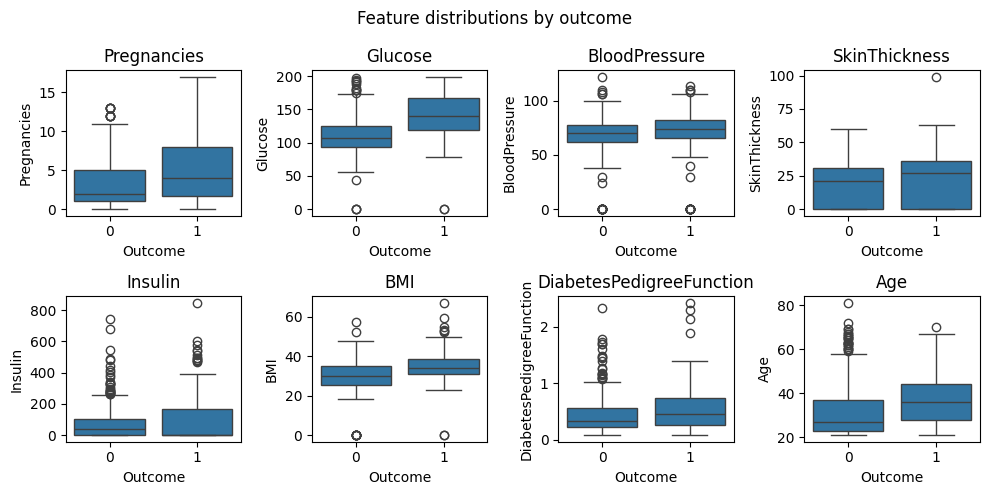

In [8]:
# Create subplot grid for boxplots (2 rows, 4 columns)
fig, axs = plt.subplots(2,4, figsize=(10,5))

# Flatten to make indexing easier
axs = axs.flatten()

fig.suptitle('Feature distributions by outcome')

# Create boxplot for each feature, grouped by diabetes outcome
for i, feature in enumerate(features):
    
    # Use seaborn boxplot to show distribution differences between outcome classes
    sns.boxplot(data_df, x='Outcome', y=feature, ax=axs[i])
    axs[i].set_title(feature)

# Adjust layout to prevent overlapping
fig.tight_layout()

### 2.3. Missing data

Medical datasets often have missing values encoded as zeros, since measurements like blood pressure or BMI cannot naturally be zero in living patients. We analyze the frequency of zero values across features to identify which ones likely contain missing data that needs imputation.

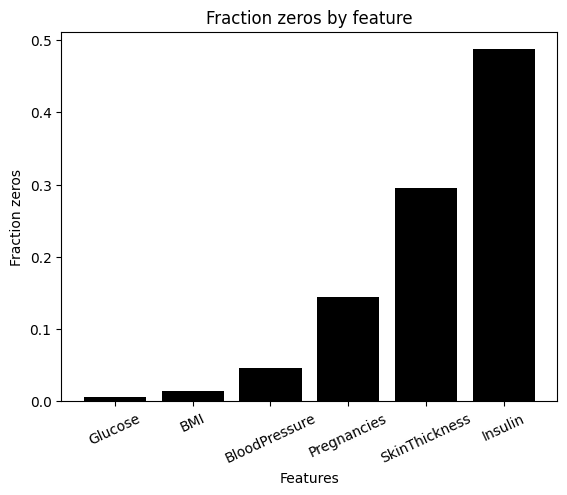

In [9]:
# Calculate the fraction of zero values for each feature in training data
zero_fraction = (data_df[features] == 0).astype(int).sum(axis=0) / len(data_df)
zero_fraction.sort_values(inplace=True)             # Sort from lowest to highest
zero_fraction = zero_fraction[zero_fraction > 0.0]  # Keep only features with zeros

# Visualize the fraction of zero values by feature
plt.title('Fraction zeros by feature')
plt.bar(zero_fraction.index, zero_fraction, color='black')
plt.xticks(rotation=25)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Fraction zeros')
plt.show()

Based on the analysis above, we select features with significant zero values for imputation. These features represent medical measurements that cannot realistically be zero, so we'll use K-Nearest Neighbors imputation to replace these missing values with estimates based on similar patients.

In [10]:
# Choose which features to apply imputation to
imputed_features = ['Glucose','BMI','BloodPressure','SkinThickness','Insulin']

# Save the list of imputed features
with open(config.IMPUTED_FEATURES_FILE, 'wb') as output_file:
    pickle.dump(imputed_features, output_file)

## 3. Data preparation

### 3.1. Feature selection

We define our final feature set for modeling. All 8 features are medical measurements that could potentially indicate diabetes risk:
- **Pregnancies**: Number of pregnancies (diabetes can develop during pregnancy)
- **Glucose**: Blood glucose level (primary diabetes indicator)
- **Blood Pressure**: Diastolic blood pressure
- **Skin Thickness**: Triceps skin fold thickness
- **Insulin**: Serum insulin level
- **BMI**: Body mass index (weight/height²)
- **Diabetes Pedigree Function**: Genetic predisposition score
- **Age**: Patient age

In [11]:
# Define the final feature set for modeling
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
            'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Define the target variable
label = ['Outcome']

# Keep only the selected features and target variable in both datasets
data_df = data_df[features + label]

### 3.2. Test-train split

We split our data into training and testing sets to evaluate model performance on unseen data. Key aspects:
- **50-50 split**: Half for training, half for testing
- **Stratified split**: Maintains the same proportion of diabetic vs non-diabetic patients in both sets
- **Random seed**: Ensures reproducible results across runs
- **Purpose**: Training set builds the model, testing set provides unbiased performance evaluation

In [12]:
# Split the dataset into training and testing sets (50-50 split)
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.5,                    # Use half the data for testing
    random_state=config.RANDOM_SEED,  # Ensure reproducible results
    stratify=data_df['Outcome']       # Maintain class distribution in splits
)

# Display the size of each split
print(f'Training set: {len(training_df)} rows')
print(f'Testing set: {len(testing_df)} rows')

Training set: 384 rows
Testing set: 384 rows


### 3.3. Save

We save the split datasets for use in other notebooks. This ensures:
- **Consistency**: All notebooks use the exact same training/testing split
- **Efficiency**: Other notebooks can skip data preparation steps
- **Reproducibility**: Results are comparable across different experiments

In [13]:
# Create directory for processed data if it doesn't exist
Path('../data/processed').mkdir(exist_ok=True, parents=True)

# Package training and testing data together for easy loading in other notebooks
data = {
    'training': training_df,
    'testing': testing_df
}

# Save processed data as pickled dictionary
with open(config.DATA_FILE, 'wb') as output_file:
    pickle.dump(data, output_file)

## 4. Model training

Now we begin the machine learning phase. We'll train and evaluate several models:
1. **Baseline models**: Simple benchmarks to establish minimum performance
2. **Decision tree**: Our main focus - a interpretable tree-based classifier
3. **Hyperparameter optimization**: Fine-tune the decision tree for best performance

We track cross-validation scores for all models to enable fair comparison.

In [14]:
# Initialize dictionary to store cross-validation scores for model comparison
cross_val_scores = {
    'Model': [],  # Model names
    'Score': []   # Accuracy scores
}

### 4.1. Baseline

#### 4.1.1. Constant '0' model

Our simplest baseline: always predict "no diabetes" (the majority class). This represents the accuracy we'd get by making the most common prediction for every patient. Any useful model must significantly outperform this naive approach.

In [15]:
# Calculate accuracy for a naive baseline that always predicts "no diabetes" (class 0)
# This represents the accuracy if we simply predicted the majority class
accuracy = ((len(training_df) - sum(training_df['Outcome'])) / len(training_df))*100
print(f'Training accuracy of constant "0" model: {accuracy:.1f}%')

Training accuracy of constant "0" model: 65.1%


#### 4.1.2. Logistic regression model

Our second baseline uses logistic regression - a simple, interpretable linear model. This pipeline includes:
- **KNN Imputation**: Fill missing values using similar patients
- **Class weighting**: Handle the imbalanced dataset (more non-diabetic than diabetic patients)
- **High iteration limit**: Ensure the optimization converges to the best solution

This provides a more sophisticated baseline that actually uses the feature data.

In [16]:
knn_imputer = ColumnTransformer([('imputer', KNNImputer(), imputed_features)], remainder='passthrough')

logistic_model = LogisticRegression(
    max_iter=5000,                     # Increase iterations to ensure convergence
    class_weight=config.CLASS_WEIGHT,  # Handle class imbalance
    random_state=config.RANDOM_SEED    # Ensure reproducible results
)

linear_model = Pipeline(
    steps=[
        ('imputer', knn_imputer),
        ('classifier', logistic_model)
    ]
)

# Train the logistic regression model
linear_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Calculate training accuracy
accuracy = accuracy_score(linear_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of logistic regression: {accuracy:.1f}%')

Training accuracy of logistic regression: 72.9%


Cross-validation provides a more reliable estimate of model performance by:
- **Multiple evaluations**: Testing the model on different data subsets
- **Reducing overfitting bias**: Single train-test splits can be misleading
- **Statistical confidence**: Mean and standard deviation show performance stability
- **Fair comparison**: All models evaluated using the same cross-validation strategy

In [17]:
# Perform cross-validation to get a more robust estimate of model performance
scores = cross_val_score(
    linear_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for later comparison
cross_val_scores['Model'].extend(['Logistic regression']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy of logistic regression: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy of logistic regression: 72.9 +/- 5.6%


### 4.2. Decision tree classifier

Now we introduce our main model: the decision tree classifier. Decision trees offer several advantages:
- **Interpretability**: Easy to understand the decision logic
- **No assumptions**: Don't assume linear relationships like logistic regression
- **Handle interactions**: Automatically capture complex feature interactions
- **Class weighting**: Handle imbalanced data effectively

We start with default hyperparameters to establish baseline decision tree performance.

In [18]:
# Create a decision tree classifier with default hyperparameters
tree_model = DecisionTreeClassifier(
    class_weight=config.CLASS_WEIGHT,  # Handle class imbalance
    random_state=config.RANDOM_SEED    # Ensure reproducible results
)

naive_model = Pipeline(
    steps=[
        ('KNN', knn_imputer),
        ('classifier', tree_model)
    ]
)

# Train the naive decision tree model
naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Calculate training accuracy
accuracy = accuracy_score(naive_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of decision tree: {accuracy:.1f}%')

Training accuracy of decision tree: 100.0%


We apply the same cross-validation approach to the decision tree to fairly compare its performance with logistic regression. The results will show whether the tree-based approach offers any advantage over the linear model for this diabetes prediction task.

In [19]:
# Perform cross-validation on the naive decision tree
scores = cross_val_score(
    naive_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for later comparison with other models
cross_val_scores['Model'].extend(['Decision tree']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results
print(f'Cross-validation accuracy of decision tree: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy of decision tree: 70.6 +/- 5.4%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter search

Hyperparameter optimization can significantly improve model performance. We use randomized search to efficiently explore the hyperparameter space:

**Imputation parameters**: Control how missing values are filled
**Tree structure**: Depth, split criteria, minimum samples per leaf
**Regularization**: Prevent overfitting through complexity constraints

The `%%time` magic command tracks how long this computationally intensive process takes.

In [20]:
%%time

# Define the hyperparameter search space for decision tree optimization
hyperparameters = {
    'KNN__imputer__n_neighbors': randint(1, 3),
    'KNN__imputer__weights': ['uniform', 'distance'],
    'KNN__imputer__add_indicator': [True, False],
    'classifier__criterion':['gini','entropy','log_loss'],
    'classifier__splitter':['best','random'],
    'classifier__max_depth':randint(1, 20),
    'classifier__min_samples_split':randint(2, 20),
    'classifier__min_samples_leaf':randint(1, 20),
    'classifier__min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'classifier__max_features':uniform(loc=0.1, scale=0.9),
    'classifier__max_leaf_nodes':randint(2, 100),
    'classifier__min_impurity_decrease':loguniform(10**-5, 1.0),
    'classifier__ccp_alpha':loguniform(10**-5, 10.0)
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    naive_model,
    hyperparameters,
    return_train_score=True,                 # Return training scores for analysis
    cv=config.CROSS_VAL_FOLDS,               # Number of cross-validation folds
    n_jobs=-1,                               # Use all available CPU cores
    n_iter=config.RANDOM_SEARCH_ITERATIONS,  # Number of parameter combinations to try
    random_state=config.RANDOM_SEED,         # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in winning_hyperparameters.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 KNN__imputer__add_indicator: False
 KNN__imputer__n_neighbors: 1
 KNN__imputer__weights: uniform
 classifier__ccp_alpha: 1.1079381204441933e-05
 classifier__criterion: entropy
 classifier__max_depth: 15
 classifier__max_features: 0.7291957233390506
 classifier__max_leaf_nodes: 28
 classifier__min_impurity_decrease: 0.003780535376190756
 classifier__min_samples_leaf: 14
 classifier__min_samples_split: 10
 classifier__min_weight_fraction_leaf: 0.3196661630588475
 classifier__splitter: best

Run time (20 CPUs):

CPU times: user 15min 50s, sys: 11.4 s, total: 16min 2s
Wall time: 16min 56s


### 4.2. Hyperparameter optimization results

We visualize the hyperparameter search results to understand:
- **Training vs validation performance**: Check for overfitting
- **Best parameter combinations**: Which settings work best
- **Performance distribution**: How much hyperparameters matter
- **Optimization effectiveness**: Whether we found good solutions

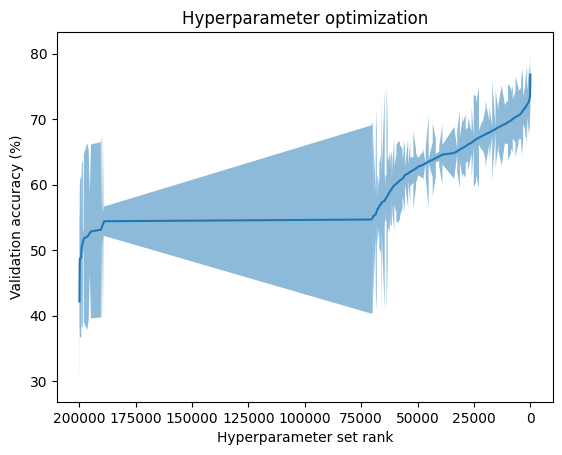

In [21]:
funcs.plot_cross_validation(search_results)

### 4.3. Cross-validation of optimized model

We evaluate the optimized decision tree using the same cross-validation procedure to get a fair comparison with our baseline models. This will show us the performance improvement gained through hyperparameter tuning.

In [22]:
# Perform cross-validation on the optimized decision tree model
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with other models
cross_val_scores['Model'].extend(['Optimized decision tree']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results for the optimized model
print(f'Optimized decision tree cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized decision tree cross-validation accuracy: 76.8 +/- 2.7%


## 5. Evaluation

### 5.1. Model comparison

A side-by-side comparison of all models using boxplots shows:
- **Performance distribution**: Spread of cross-validation scores
- **Model ranking**: Which models perform best on average
- **Consistency**: Which models are most reliable (smaller variance)
- **Statistical significance**: Whether performance differences are meaningful

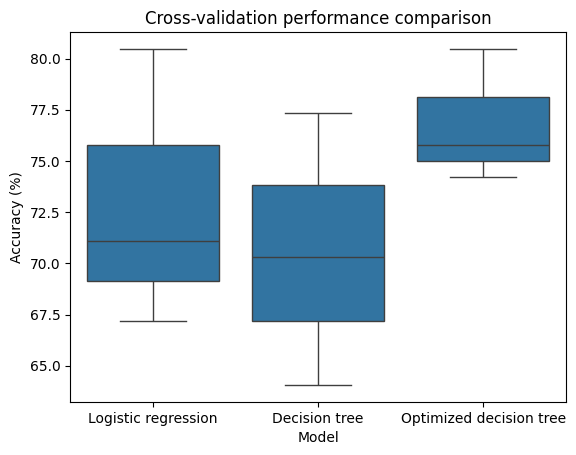

In [23]:
# Create boxplot to compare cross-validation performance across all models
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

Final evaluation on the held-out test set provides the true measure of model performance on unseen data. Confusion matrices reveal:
- **True positive rate**: How many diabetic patients were correctly identified
- **False positive rate**: How many healthy patients were misclassified as diabetic
- **Overall accuracy**: Total correct predictions
- **Class-specific performance**: Which class each model predicts better

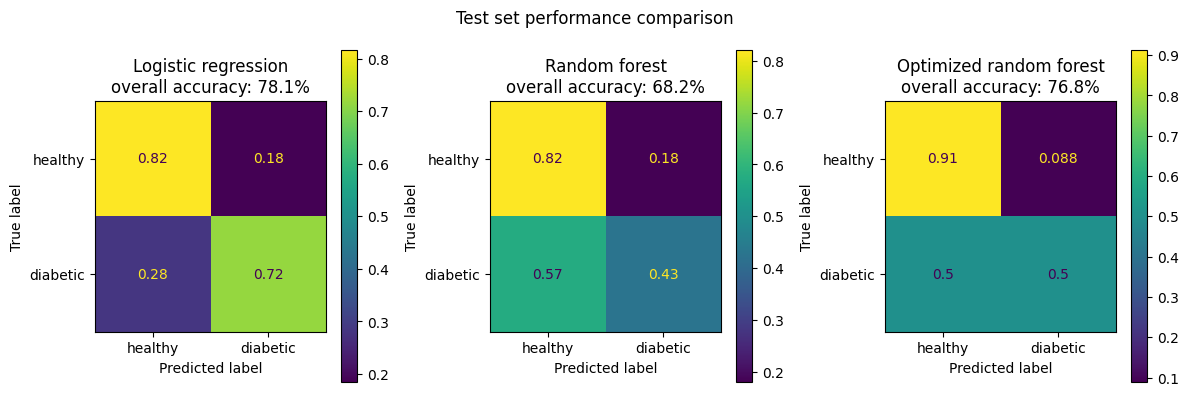

In [24]:
# Train the naive and winning models on the full training set for final evaluation
result = naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
result = best_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Generate confusion matrices for both random forest models on the test set
funcs.plot_confusion_matrices(
    models = {
        'Logistic regression': linear_model,
        'Random forest': naive_model,
        'Optimized random forest': best_model
    },
    testing_df=testing_df
)

## 6. Save

### 6.1. Scores

We save our results for future analysis and comparison with other algorithms (random forests, gradient boosting, etc.). This maintains a complete record of model performance across the entire project.

In [25]:
# Save cross-validation scores for comparison with other algorithms
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

### 6.2. Models

Finally, we save the trained models and their hyperparameters for:
- **Deployment**: Using the best model in production
- **Reproducibility**: Recreating the exact same model later
- **Analysis**: Comparing with other algorithms in subsequent notebooks
- **Documentation**: Recording what worked best for this dataset

In [26]:
# Create directory for model storage if it doesn't exist
Path('../models').mkdir(exist_ok=True, parents=True)

# Save the optimal hyperparameters for future use or reproduction
with open(config.DECISION_TREE_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

# Save the trained best model for deployment or further analysis
with open(config.DECISION_TREE_MODEL, 'wb') as output_file:
    pickle.dump(best_model, output_file)

# Save the linear model for comparison later
with open(config.LOGISTIC_REGRESSION_MODEL, 'wb') as output_file:
    pickle.dump(linear_model, output_file)